# Introduction to Topic Modeling
## Day 2: Visualization and Evaluation
---
---

## Outline
- [Load the data](#data)
- [Vectorize and train](#train)
- [Visualize topic words with `wordcloud`](#cloud)
- [Words aligned with each topic](#words)
- [Topic prevalence over time](#time)
- [Visualising topics with pyLDAvis](#viz)
- [Evaluating the topic model](#eval)
- [Resources and alternatives](#resources)

## Load data

In [1]:
import pandas as pd
import numpy as np

df_lit = pd.read_csv("../assets/childrens_lit.csv.bz2", sep='\t', index_col=0, encoding = 'utf-8', compression='bz2')
df_lit = df_lit.dropna(subset=['text']) # drop where missing text

## Vectorize and train <a id='train'></a>

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.80, min_df=50,
                                max_features=None,
                                stop_words='english')

# Create sparse DTM
tf_dtm = tf_vectorizer.fit_transform(df_lit.text)

tf_vocab = tf_vectorizer.get_feature_names() # Save vocabulary for later use

/home/jhaber/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_samples = 2000
n_topics = 4
n_top_words = 50

print("Fitting LDA model with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

tf_lda = LDA(n_components=n_topics, 
          max_iter=20,
          learning_method='online',
          learning_offset=80.,
          total_samples=n_samples,
          random_state=0)

#fit the model
tf_lda.fit(tf_dtm)
print("Done!")

Fitting LDA model with tf features, n_samples=2000 and n_topics=4...
Done!


In [4]:
def print_top_words(model, feature_names, n_top_words):
    '''Prints the top words for each topic in a pretty way.'''
    
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
# print top words
print("\nTopics in LDA model with TF features and %d topics:" % n_topics)
print_top_words(tf_lda, tf_vocab, n_top_words)


Topics in LDA model with TF features and 4 topics:

Topic #0:
project doctor girls sister papa mamma london baby sweet tom street works dr remarked aunt tea youth foundation presently study em ain cousin office darling loved ladies wasn everybody public flower observed nurse ma shop snow ye queen class reader ice stairs flowers lovely agreement sisters doesn carriage bell garden

Topic #1:
dick uncle doctor er jack ain tom den yer fish em rock wolf gun rope lads ha birds rocks beneath ay stream shock tail moments mate excitedly garden eh sand fishing thrust ye nay gazing softly mountain ship tremendous hook bird leg ashore growled penny shore stones farther jump knife

Topic #2:
king army french troops camp attack officers prince ship john soldiers city village officer guns rode shore regiment march tom fort wounded british boats sword advanced castle jack james indian band marched native prisoners ships arrows france numbers lads forest frank ride presently vessel fought mounted flee

### Challenge 1

Use `sklearn`'s `TfidfVectorizer()` function ([more info here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) to weight features with TF-IDF. Extract the vectorizer vocabulary for later use. 

In [5]:
# solution

from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize our text using TfidfVectorizer
print("Extracting tf-idf features for LDA...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=50,
                                   max_features=None,
                                   stop_words='english')

# Create sparse DTM with TF-IDF weighting
tfidf_dtm = tfidf_vectorizer.fit_transform(df_lit.text)

tfidf_vocab = tfidf_vectorizer.get_feature_names() # Save vocabulary for later use
print("Done!")

Extracting tf-idf features for LDA...
Done!


### Challenge 2

Train an LDA model using the TF-IDF-weighted. Then use the `print_top_words()` function defined above to display the top words for each topic. Compare with the output we just saw from the model trained using term frequencies.

In [6]:
# solution
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_samples = 2000
n_topics = 4
n_top_words = 50

print("Fitting LDA model with tf-idf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

tfidf_lda = LDA(n_components=n_topics, 
          max_iter=20,
          learning_method='online',
          learning_offset=80.,
          total_samples=n_samples,
          random_state=0)

# fit the model
tfidf_lda.fit(tfidf_dtm)
print("Done!")

# print top words per topic
print("\nTopics in LDA model with TF-IDF features and %d topics:" % n_topics)
print_top_words(tfidf_lda, tfidf_vocab, n_top_words)

Fitting LDA model with tf-idf features, n_samples=2000 and n_topics=4...
Done!

Topics in LDA model with TF-IDF features and 4 topics:

Topic #0:
project papa dick mass mail ma doctor moonlight folks foundation mamma tiny seating shouldn island lake minded select loved shone wont minister beauty discussed believing plunged songs south dreary cliffs desired subdued rejoiced wounds reported riding entertainment delicate tea calculate dr sufficed pipe wicked remarked charged undertaking arrival brush animal

Topic #1:
dick fish sunk distinguished guns drifted suited consisting charming tail subsided peril attempted powder invalid blame plate prize unusual granted respected stunned solid reported amazement facing reputation stock clapping scratched string larger profit meat supposing pour tower bleeding climbing tie awe bade stolen absurd disaster rattle keen honestly plunged tumbled

Topic #2:
project doctor king dick tom uncle camp ship jack girls prince troops french em army shore ye de

### Stemming <a id='stem'></a>

In [7]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

### Challenge

Implement stemming with the PorterStemmer on our children's books. Then vectorize the text, construct an LDA model, and compare the results to what you saw before.

_Hint:_ Create a new DF column called `text_stemmed` with the stemmed version of the book text. Use an `apply()` function with a list comprehension to implement the stemming algorithm to each word in each text. The basic format for this is:

```python
df[col_new] = df[col].apply(lambda doc: ' '.join([function(word) for word in doc.split()]))
```

In [8]:
# solution

print("Stemming text (this may take a while)...")
df_lit['text_stemmed'] = df_lit.text.apply(lambda doc: ' '.join([ps.stem(word) for word in doc.split()]))
print("Done!")

# Vectorize our text using TfidfVectorizer
print("Extracting tf features for LDA...")
tfidf_vectorizer_stemmed = TfidfVectorizer(max_df=0.80, min_df=50,
                                           max_features=None, 
                                           stop_words='english')

tfidf_dtm_stemmed = tfidf_vectorizer_stemmed.fit_transform(df_lit.text_stemmed)
print("Done!")

tfidf_vocab_stemmed = tfidf_vectorizer_stemmed.get_feature_names() # save terms in vectorizer for later use 

n_samples = 2000
n_topics = 4
n_top_words = 50

print("Fitting LDA model with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

#define the lda function, with desired options
#Check the documentation, linked above, to look through the options
tfidf_lda_stemmed = LDA(n_components=n_topics, 
          max_iter=20,
          learning_method='online',
          learning_offset=80.,
          total_samples=n_samples,
          random_state=0)

#fit the model
tfidf_lda_stemmed.fit(tfidf_dtm_stemmed)
print("Done!")

print("\nTopics in LDA model:")
print_top_words(tfidf_lda_stemmed, tfidf_vocab_stemmed, n_top_words)

Stemming text (this may take a while)...
Done!
Extracting tf features for LDA...
Done!
Fitting LDA model with tf features, n_samples=2000 and n_topics=4...


/home/jhaber/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Done!

Topics in LDA model:

Topic #0:
er plenty ain french pig yer princ ma gun hidden jame undoubtedli snow precis farther proceedings bridg volley exceedingli flower endeavour unseen wrench queen village waited em stupid services yell forgiv rescu clatter hunting borrow camp choic enemi suspici awkward treasure educ arous season presently absenc rode flock cordial pli

Topic #1:
regiment pant lies lump army height ray fret arrow drown volum nonsense exhaust woke shrank tom western contribut prosper convuls enemy villag choke descript glisten gestur court sum cases wive rocki mass som expens prisoner egg bind fighting lash easily reviv slender crow column blast mountain eas chase steel confidenti

Topic #2:
dick uncl grin village discovery ray horses widow disappeared halt bob limit loosen dignity visitors succeeded dropped em ye berth nativ mayb copi liberti fat abruptly accordingli beasts sum outburst rooms indulg display beckon deeply celebr wage elect defenc endeavour scowl summo

## Visualize topic words with `wordcloud` <a id='cloud'></a>

In [9]:
import wordcloud
from matplotlib import pyplot as plt

def display_wordcloud(model, feature_names, terms_count, save=False):
    '''Creates a word cloud with specified # terms for each topic in input topic model. 
    Credit for example code: Krunal on Medium: https://medium.com/@krunal18/topic-modeling-with-latent-dirichlet-allocation-lda-decomposition-scikit-learn-and-wordcloud-1ff0b8e8a8eb)
    
    Args:
        model (object): topic model from LatentDirichletAllocation (like lda)
        feature_names (array): vocabulary from text vectorizer
        terms_count (int): number of terms to include for each topic's word cloud
        save (binary): whether to display in notebook or save wordclouds to disk
    
    Returns:
        wordcloud visualizations'''

    for idx,topic in enumerate(model.components_): # loop over topics
        print('Topic# ',idx+1)
        
        # Get N top words for each topic as a list of lists
        topic_terms_sorted = [[feature_names[i], topic[i]] for i in topic.argsort()[:-terms_count - 1:-1]]

        topic_words = []

        # Print top words above each wordcloud
        for i in range(terms_count):
            topic_words.append(topic_terms_sorted[i][0])
        print(','.join( word for word in topic_words))
        print()

        dict_word_frequency = {}

        for i in range(terms_count):
            dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

        # Initialize wordcloud
        wcloud = wordcloud.WordCloud(background_color="white",mask=None, max_words=100, 
                                     max_font_size=100,min_font_size=10,prefer_horizontal=0.9,
                                     contour_width=3,contour_color='black', 
                                     min_word_length=3)

        wcloud.generate_from_frequencies(dict_word_frequency)

        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")

        # Visual done, now save or display
        if save:
            plt.savefig("WordCloud Topic "+str(idx+1)+".png", format="png")
        else:
            plt.show()

### Challenge

Create a new LDA model called `tfidf_lda_stemmed` with 10 topics, TF-IDF weighting, and stemmed words. Then create a word cloud for each topic with the top 75 words.

Fitting LDA model with tf-idf features, n_samples=2000 and n_topics=10...
Done!
Topic#  1
camp,plenty,jame,french,pig,gun,hidden,dick,snow,precis,ain,undoubtedli,bridg,proceedings,village,farther,volley,ma,exceedingli,endeavour,princ,er,nativ,tom,yell,unseen,wrench,waited,services,enemi,stupid,rescu,armi,forgiv,project,rode,queen,em,clatter,hunting,choic,indian,borrow,period,educ,arous,absenc,awkward,season,suspici,labour,band,approaching,cordial,flock,yer,treasure,pli,total,partial,presently,hallo,concerned,suffic,hut,tremend,rocks,fort,wive,autumn,000,mast,lion,star,fold



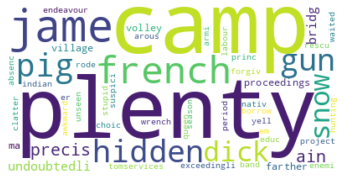

Topic#  2
lies,arrow,lump,pant,height,ray,fret,drown,volum,army,woke,regiment,western,shrank,exhaust,contribut,nonsense,convuls,prosper,descript,gestur,choke,cases,court,rocki,sum,wive,som,expens,bind,glisten,egg,easily,lash,reviv,crow,mass,slender,fighting,chase,eas,whistle,blast,mountain,envelop,furiously,confidenti,spirits,tom,overtak,ugli,candl,sleeper,column,enemy,bearer,villag,hunter,absenc,ghost,steel,prisoner,reduc,scent,sh,bushes,accommod,citi,attacked,hunting,erect,suggested,scoundrel,wherea,filled



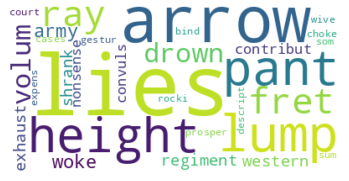

Topic#  3
dick,ye,grin,uncl,village,discovery,horses,ray,widow,em,disappeared,halt,limit,loosen,dignity,succeeded,mayb,visitors,dropped,bob,berth,copi,fat,liberti,abruptly,accordingli,sum,beasts,beckon,rooms,outburst,display,indulg,deeply,celebr,rode,endeavour,steal,wage,desol,dig,sold,defenc,scowl,neighbourhood,summon,streets,approv,envelop,firm,danc,wherev,proclaim,elect,detach,solemnli,try,band,basket,faster,uneasi,explanation,doors,bodies,nativ,crest,lamp,utterli,warning,offend,really,branches,crew,hills,shift



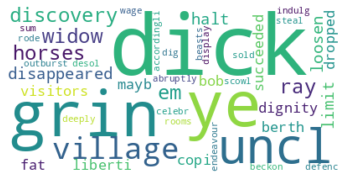

Topic#  4
mrs,project,dick,uncl,tom,ye,bob,mamma,papa,island,indian,ain,yer,em,jack,shore,camp,aunt,deck,london,dr,cousin,ma,john,distribut,tea,copi,mountain,gun,er,agreement,crew,vessel,tim,queen,lake,mate,uncle,forest,hut,st,ice,snow,gray,flower,shop,sailor,ay,foundat,public,georg,wreck,frank,reader,wasn,soldier,hunter,nativ,class,babi,refer,cabin,girls,south,court,grey,church,jame,sand,unit,hero,horse,everybodi,shoot,bush



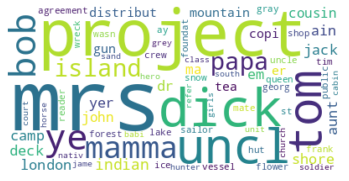

Topic#  5
mrs,jack,project,strive,ice,patience,brute,protest,john,pit,agoni,brilliant,centr,em,basket,uncle,papa,respond,purs,valley,guardian,debt,hotel,office,uncl,eastern,ugli,presence,cousin,connect,st,tower,readili,rejoic,awaken,received,brow,exult,fring,gentlemen,bandag,sooth,control,string,profit,music,comb,salli,novel,dr,finest,bench,stalk,eldest,frame,conscious,finished,hut,sharpli,dealt,thou,unit,recogn,sunshin,chamber,ropes,domest,marriag,aunt,audienc,prayer,wrought,hero,desk,thee



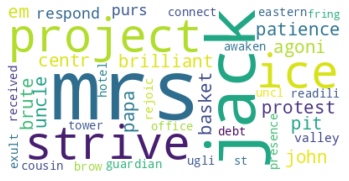

Topic#  6
wine,stars,island,indian,turning,intellig,slice,price,fly,tent,lake,thread,xi,awak,rattl,flag,shove,childhood,princip,married,momentari,mood,abruptly,solid,rail,voyag,fleet,spin,approached,slave,lantern,forest,cellar,sandi,compos,whistle,choke,ridg,prepared,gratitude,fade,utterli,rug,horse,finished,hidden,preserv,exercise,castl,ashor,handsome,domest,stow,dens,bend,caution,promptli,picture,soil,elbow,gay,strongli,seconds,000,remember,hadn,gap,homes,giant,rat,chiefli,pursuit,officers,embrac,overtak



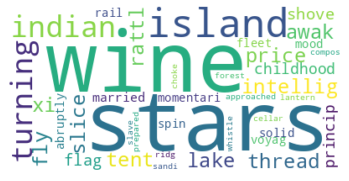

Topic#  7
bob,jack,mrs,yer,em,uncl,tom,mayb,horse,soldier,project,babi,shop,ain,london,dick,fret,infant,john,bell,uncle,surfac,married,fool,sunday,shan,pit,dr,hearti,pleased,flung,commun,pursu,involv,moor,enrag,prize,glisten,doubtless,dignity,baby,cousin,exercis,jame,interested,wounded,vessel,altern,paused,shoot,grumbl,circumst,guilti,waiting,flood,flame,perceiv,glow,jar,york,cause,chap,invari,hiding,gun,gray,endeavour,ere,deni,altogeth,unmistak,imagination,agreeabl,indignation,cowardli



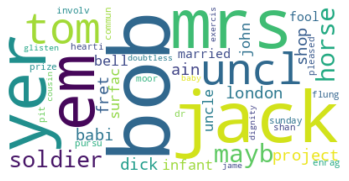

Topic#  8
haunt,latin,names,french,tim,loosen,awak,terrifi,astonishment,disappointed,dwelt,alight,ach,instinct,captur,jar,vacant,lain,digniti,mode,version,wrist,lantern,wanted,degre,reading,interesting,altogether,snake,select,looks,certainti,avail,countenance,abroad,invest,exhaust,price,ye,ma,paddl,pressur,emerg,sheer,perch,articl,scheme,dish,convict,undertaken,lake,married,delay,weren,track,language,beginning,thunder,glisten,lunch,movements,cloak,rib,equip,compel,basin,jack,looking,stifl,ag,decent,shi,overheard,circuit,fishing



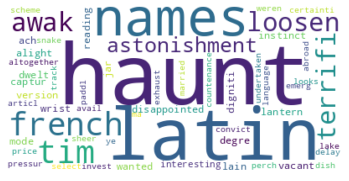

Topic#  9
princ,french,troop,regiment,armi,camp,soldier,rode,major,sword,enemi,army,nativ,john,tom,enemy,vessel,gun,dick,villag,fort,shore,british,horse,fleet,arrow,citi,tent,column,captur,jack,gate,forest,band,general,governor,officers,hut,island,spanish,horses,defend,william,village,leader,valley,assault,deck,mrs,city,battl,sailor,defeat,soldiers,officer,royal,london,castl,walls,fought,crew,queen,guns,lake,halt,rear,000,mountain,force,honour,coast,retreat,pursuit,gallop,court



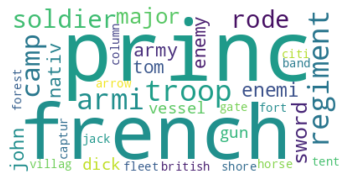

Topic#  10
mrs,frank,obedi,uncle,agreeabl,mamma,youngster,glisten,chuckl,pursu,intern,kindly,agreement,chamber,trick,instrument,altern,basket,kneel,scare,governor,pierc,admiration,construct,prayer,beauty,crying,importance,shoe,toil,battl,warmth,ere,history,intention,falling,carriag,shell,slung,nestl,york,prepared,beard,oppress,council,frown,passage,clumsi,recovered,feather,dealt,affairs,suggestion,assum,termin,bridg,region,veil,furiously,poison,oppos,injuri,entitl,eating,limb,instance,messag,effectu,daili,cousin,satisfaction,distinctli,moral,complain,fulfil



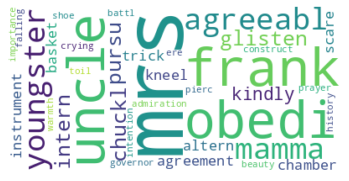

In [10]:
# solution 

# This assumes we already have dtm_stemmed and vocab_stemmed (see code above)

n_samples = 2000
n_topics = 10

print("Fitting LDA model with tf-idf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

#define the lda function, with desired options
#Check the documentation, linked above, to look through the options
tfidf_lda_stemmed = LDA(n_components=n_topics, 
                  max_iter=20,
                  learning_method='online',
                  learning_offset=80.,
                  total_samples=n_samples,
                  random_state=0)

#fit the model
tfidf_lda_stemmed.fit(tfidf_dtm_stemmed)
print("Done!")

cloud_size_terms = 75

display_wordcloud(tfidf_lda_stemmed, tfidf_vocab_stemmed, cloud_size_terms)

## Words aligned with each topic <a id='words'></a>

In [11]:
# Get topic distribution and merge with main DataFrame
topic_dist = tf_lda.transform(tf_dtm)
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(df_lit)

In [12]:
# create word count column
df_w_topics['word_count'] = df_w_topics['text'].apply(lambda x: len(str(x).split()))
df_w_topics['word_count']

0       96493
1      100603
2       85132
3       92822
4       48251
        ...  
122     68589
123     76593
124     56018
125     53942
126    108275
Name: word_count, Length: 127, dtype: int64

In [13]:
# multiply topic weight by word count
df_w_topics['0_wc'] = df_w_topics[0] * df_w_topics['word_count']
df_w_topics['0_wc']

0      89544.893129
1       2750.319905
2      82773.973483
3      92813.400143
4      46769.319262
           ...     
122        3.232002
123    73544.948175
124        1.447412
125        1.081305
126        2.422885
Name: 0_wc, Length: 127, dtype: float64

In [14]:
# create a for loop to do this for every topic
col_list = []
topic_columns = range(0,4)

for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    df_w_topics[col] = df_w_topics[num] * df_w_topics['word_count']
    
df_w_topics

,0,1,2,3,title,author gender,year,text,text_stemmed,word_count,0_wc,1_wc,2_wc,3_wc
0,0.927994,0.014370,0.057603,0.000034,A Dog with a Bad Name,Male,1886.0,A DOG WITH A BAD NAME BY TALBOT BAINES REED ...,a dog with a bad name by talbot bain reed chap...,96493,89544.893129,1386.608095,5558.264002,3.234773
1,0.027338,0.070131,0.491328,0.411202,A Final Reckoning,Male,1887.0,A Final Reckoning: A Tale of Bush Life in Aust...,a final reckoning: a tale of bush life in aust...,100603,2750.319905,7055.421499,49429.084933,41368.173663
2,0.972302,0.000037,0.022598,0.005064,"A House Party, Don Gesualdo, and A Rainy June",Female,1887.0,A HOUSE-PARTY Don Gesualdo and A Rainy June...,a house-parti don gesualdo and a raini june by...,85132,82773.973483,3.116905,1923.824216,431.085396
3,0.999907,0.000031,0.000031,0.000031,A Houseful of Girls,Female,1889.0,"A HOUSEFUL OF GIRLS. BY SARAH TYTLER, AUTHOR ...","a hous of girls. by sarah tytler, author of ""c...",92822,92813.400143,2.846490,2.882587,2.870780
4,0.969292,0.028883,0.000061,0.001764,A Little Country Girl,Female,1885.0,"LITTLE COUNTRY GIRL. BY SUSAN COOLIDGE, ...","littl countri girl. by susan coolidge, author ...",48251,46769.319262,1393.626070,2.921490,85.133178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.000047,0.000047,0.000048,0.999858,Treasure Island,Male,1883.0,TREASURE ISLAND by Robert Louis Stevenson ...,treasur island by robert loui stevenson treasu...,68589,3.232002,3.214454,3.282020,68579.271523
123,0.960205,0.000054,0.005191,0.034551,Twice Bought,Male,1885.0,"The Project Gutenberg EBook of Twice Bought, b...","the project gutenberg ebook of twice bought, b...",76593,73544.948175,4.102616,397.586668,2646.362541
124,0.000026,0.000025,0.999923,0.000026,Two Arrows,Male,1886.0,TWO ARROWS HARPER'S YOUNG PEOPLE'S SERIES...,two arrow harper' young people' seri new large...,56018,1.447412,1.423235,56013.692946,1.436407
125,0.000020,0.000020,0.999940,0.000020,Uncle Remus: His Songs and Sayings,Male,1880.0,Uncle Remus: His Songs and His Sayings By Joe...,uncl remus: hi song and hi say by joel chandle...,53942,1.081305,1.091519,53938.737610,1.089566


### Challenge 1

- What is the total number of words aligned with each topic, by author gender?
- What is the proportion of total words aligned with each topic, by author gender?

In [15]:
# solution
grouped = df_w_topics.groupby('author gender')
for e in col_list:
    print(e)
    print(grouped[e].sum())

0_wc
author gender
Female    1.150752e+06
Male      2.460418e+06
Name: 0_wc, dtype: float64
1_wc
author gender
Female    1.484812e+05
Male      1.719037e+06
Name: 1_wc, dtype: float64
2_wc
author gender
Female    1.392767e+05
Male      2.593460e+06
Name: 2_wc, dtype: float64
3_wc
author gender
Female    6.686701e+04
Male      1.124740e+06
Name: 3_wc, dtype: float64


In [16]:
for e in col_list:
    print(e)
    print(grouped[e].sum()/grouped['word_count'].sum())

0_wc
author gender
Female    0.764428
Male      0.311538
dtype: float64
1_wc
author gender
Female    0.098634
Male      0.217664
dtype: float64
2_wc
author gender
Female    0.092519
Male      0.328384
dtype: float64
3_wc
author gender
Female    0.044419
Male      0.142414
dtype: float64


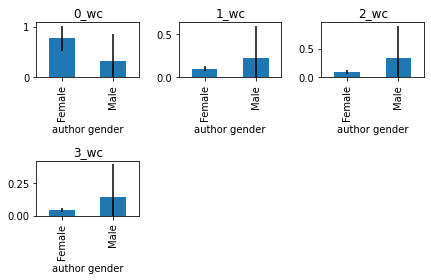

In [17]:
fig2 = plt.figure()
chrt = 0
for e in col_list:
    chrt += 1 
    ax2 = fig2.add_subplot(2,3, chrt)
    (grouped[e].sum()/grouped['word_count'].sum()).plot(
        kind = 'bar', 
        yerr = grouped[e].sum()/grouped['word_count'].sum().std(), 
        ylim=0, ax=ax2, title=e)

fig2.tight_layout()
plt.show()

### Challenge 2

- Find the most prevalent topic in the corpus.
- Find the least prevalent topic in the corpus.        

In [18]:
#solution
for e in col_list:
    print(e)
    print(df_w_topics[e].sum()/df_w_topics['word_count'].sum())

0_wc
0.3840432895308944
1_wc
0.19860793419265882
2_wc
0.29062288331375674
3_wc
0.12672589296269


## Topic prevalence over time <a id='time'></a>

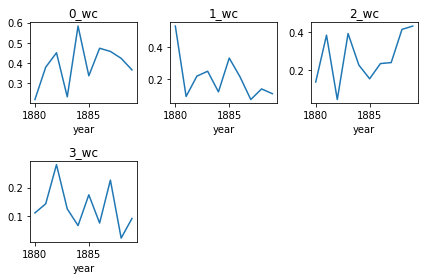

In [19]:
grouped_year = df_w_topics.groupby('year')
fig3 = plt.figure()
chrt = 0
for e in col_list:
    chrt += 1 
    ax2 = fig3.add_subplot(2,3, chrt)
    (grouped_year[e].sum()/grouped_year['word_count'].sum()).plot(
        kind='line', title=e)
    
fig3.tight_layout()
plt.show()

## Visualising topics with pyLDAvis <a id='viz'></a>

In [20]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

# Silence an annoying warning we cannot do anything about
import warnings
warnings.filterwarnings('ignore')

In [21]:
pyLDAvis.sklearn.prepare(tf_lda, tf_dtm, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.067144 -0.057703       1        1  35.723702
0      0.012048  0.063136       2        1  35.454139
1     -0.099979 -0.026718       3        1  17.201155
3      0.020787  0.021285       4        1  11.621004, topic_info=         Term         Freq        Total Category  logprob  loglift
815      dick  4914.000000  4914.000000  Default  30.0000  30.0000
1564     jack  3862.000000  3862.000000  Default  29.0000  29.0000
2989    uncle  3740.000000  3740.000000  Default  28.0000  28.0000
989        er  2337.000000  2337.000000  Default  27.0000  27.0000
870    doctor  5069.000000  5069.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1572     john   290.175681  2306.869082   Topic4  -5.9127   0.0792
2747   street   237.391109  1323.321827   Topic4  -6.1135   0.4342
1915  officer   257.116585  1703.200395   Topic4  -6.0337   0.2616
870    doctor   339.829496  5069.883998   Topic4  -5.7548  -0.5503
1255    girls   245.323294  2264.521683   Topic4  -6.0807  -0.0702

[258 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5         1  0.049988     _you_
5         2  0.864494     _you_
5         3  0.020583     _you_
5         4  0.064690     _you_
56        1  0.763321  advanced
...     ...       ...       ...
3193      4  0.030138    yonder
3196      1  0.234008     youth
3196      2  0.655812     youth
3196      3  0.040312     youth
3196      4  0.069809     youth

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

Here are some hints to help you interpret the visualisation:

* On the **left-hand side** is a scatterplot of some bubbles:
 * Each **bubble** represents a topic.
 * The **size of a bubble** represents how _prevalent_ or popular the topic is overall.
 * The **distance** from one bubble to another represents how similar the topics are to each other. If they overlap then the topics share significant similarity.
 
* On the **right-hand side** is a histogram of terms (tokens):
 * Select a bubble and it shows the top-30 **most relevant terms** for that topic.
 * The **red bar** represents how frequent a term is in the topic.
 * The **blue bar** represents how frequent the term is overall in all topics. So a long red bar with only a short blue bar indicates a term that is highly specific to that particular topic. Conversely, a red bar with a long blue bar means the term is also present in many other topics.
 * By mousing over a particular term, the size of the bubbles changes to show the relative frequency of that term in the various topics.
 * By adjusting the slide, it adjusts the **_relevance_ value (λ)**, which is the weight given to whether a term appears exclusively in a particular topic or is spread over topics more evenly. If λ = 1 terms are ranked according to their probabilities in the particular topic only; if λ = 0 terms are ranked higher if they are unusual terms that occur almost exclusively in that topic. Typically, the optimal value is around 0.6, but it is interesting to adjust it and observe any differences.

### Challenge

Use `pyLDAvis` to visualize the relationships between topics in the `tfidf_lda_stemmed` model you created earlier. What differences do you notice between this and the un-stemmed version?

In [22]:
# solution

pyLDAvis.sklearn.prepare(tfidf_lda_stemmed, tfidf_dtm_stemmed, tfidf_vectorizer_stemmed)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.007592  0.001283       1        1  82.989301
8     -0.001489 -0.004578       2        1  12.443409
6      0.000313  0.000677       3        1   0.570915
4      0.000419  0.001121       4        1   0.570914
0      0.000907  0.000099       5        1   0.570912
2      0.001075  0.000152       6        1   0.570912
9      0.001482  0.000514       7        1   0.570910
1      0.001535  0.000191       8        1   0.570909
5      0.001591  0.000121       9        1   0.570909
7      0.001760  0.000420      10        1   0.570909, topic_info=            Term      Freq     Total Category  logprob  loglift
1546         mrs  5.000000  5.000000  Default  30.0000  30.0000
1808     project  4.000000  4.000000  Default  29.0000  29.0000
657         dick  2.000000  2.000000  Default  28.0000  28.0000
2466        uncl  2.000000  2.000000  Default  27.0000  27.0000
2647          ye  2.000000  2.000000  Default  26.0000  26.0000
...          ...       ...       ...      ...      ...      ...
1005      french  0.005891  1.463776  Topic10  -7.6092  -0.3497
2389         tim  0.005818  1.561630  Topic10  -7.6217  -0.4269
74    altogether  0.005490  0.893170  Topic10  -7.6797   0.0738
2142       snake  0.005477  0.937461  Topic10  -7.6820   0.0230
2037      select  0.005463  0.884897  Topic10  -7.6846   0.0782

[646 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  1.256916          000
13        1  1.410357     abruptly
14        1  1.352380       absenc
28        1  1.541477  accordingli
31        1  1.320691          ach
...     ...       ...          ...
2643      1  1.578395           xi
2647      1  0.815302           ye
2648      1  0.940835         yell
2650      1  0.946107          yer
2655      1  1.284569    youngster

[324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 7, 5, 1, 3, 10, 2, 6, 8])

## Evaluating the topic model <a id='eval'></a>

In [23]:
from tmtoolkit.topicmod import tm_sklearn 

### Challenge

Calculate the log-likelihood, perplexity, and coherence of the `tfidf_lda_stemmed` model you created earlier. How does this model compare to the 4-topic, un-stemmed one we just examined?

In [25]:
# solution

# Log Likelihood: Higher the better
print("Log Likelihood: ", tfidf_lda_stemmed.score(tfidf_dtm_stemmed))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", tfidf_lda_stemmed.perplexity(tfidf_dtm_stemmed))

tfidf_stemmed_coherence_scores = tm_sklearn.metric_coherence_mimno_2011(topic_word_distrib = tfidf_lda_stemmed.components_, dtm = tfidf_dtm_stemmed)
print("Semantic coherence: ", tfidf_stemmed_coherence_scores)

Log Likelihood:  -36024.519787298435
Perplexity:  33043929.052165825
Semantic coherence:  [inf inf inf inf inf inf inf inf inf inf]
